## TUTORIAL 05 - Discrete Empirical Interpolation Method for non-affine elliptic problems
**_Keywords: discrete empirical interpolation method_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.
The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to obtain a faster evaluation (yet, provably accurate) of the problem we propose to use a certified reduced basis approximation for the problem. In order to preserve the affinity assumption (for the sake of performance) the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

The parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obtain an efficient (approximately affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@DEIM()
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianDEIM"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-4, DEIM=1e-8)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=60)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the pull back of $a_o$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the pull back of $f_o$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
10000 3.372924174674624e-07 	Loss(validation) = 2.946014008307347e-06
10100 3.6752991281343947e-07 	Loss(validation) = 2.9287940606081462e-06
10200 3.174115485901916e-07 	Loss(validation) = 2.8688705875962624e-06
10300 3.0924594631586055e-07 	Loss(validation) = 2.8306270081592797e-06
10400 4.11190532759443e-07 	Loss(validation) = 2.968766277088881e-06
10500 3.285061933928722e-07 	Loss(validation) = 2.744312069151439e-06
10600 2.901059806821479e-07 	Loss(validation) = 2.7205529739699605e-06
10700 3.4357502870464896e-07 	Loss(validation) = 2.7551109254685666e-06
10800 2.8795829739027425e-07 	Loss(validation) = 2.688698024992067e-06
10900 2.8078484540696434e-07 	Loss(validation) = 2.6261196061936227e-06
11000 3.31873353808554e-07 	Loss(validation) = 2.5663851315907886e-06
11100 2.6448825080922416e-07 	Loss(validation) = 2.5698358561942035e-06
11200 2.7876983727

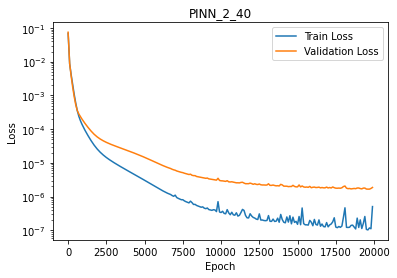

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

1700 5.192122801314327e-05 	Loss(validation) = 0.07914734468243298
1800 4.204846165935615e-05 	Loss(validation) = 0.07916499229540976
1900 3.3906261736619544e-05 	Loss(validation) = 0.07919138664573375
2000 2.712707581195823e-05 	Loss(validation) = 0.07922477421621363
2100 2.147171302537762e-05 	Loss(validation) = 0.07926435929193447
2200 1.6776816531922205e-05 	Loss(validation) = 0.07930967468154598
2300 1.2919698075669362e-05 	Loss(validation) = 0.07935996971999734
2400 9.795520930328466e-06 	Loss(validation) = 0.07941427080890096
2500 7.306676693998691e-06 	Loss(validation) = 0.07947112618081213
2600 5.359063737266367e-06 	Loss(validation) = 0.07952886188750045
2700 3.862974791720412e-06 	Loss(validation) = 0.07958582453410937
2800 2.7350957666374147e-06 	Loss(validation) = 0.07964041521560442
2900 1.9011555627953231e-06 	Loss(validation) = 0.07969091005067346
3000 1.2969884054381303e-06 	Loss(validation) = 0.07973830336556367
3100 8.693488497012604e-07 	Loss(validation) = 0.0797777

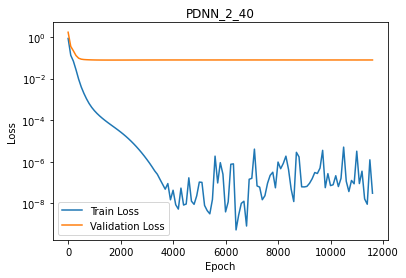

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
10000 7.383630114154988e-06 	Loss(validation) = 0.00018249439173556706
10100 6.784933144875589e-06 	Loss(validation) = 0.00017108970536977054
10200 5.637277265382515e-06 	Loss(validation) = 0.0001691418509046774
10300 1.1431301932883519e-05 	Loss(validation) = 0.00017830567634895565
10400 5.533490644474261e-06 	Loss(validation) = 0.00016385844021853316
10500 5.804298183590718e-06 	Loss(validation) = 0.00016234574204602065
10600 5.596657044563614e-06 	Loss(validation) = 0.00015789619348100938
10700 5.717171424728387e-06 	Loss(validation) = 0.00015585638382782142
10800 8.247904230267738e-06 	Loss(validation) = 0.0001566420463614764
10900 4.99532806695718e-06 	Loss(validation) = 0.00014959232549561935
11000 4.7586095879621776e-06 	Loss(validation) = 0.0001456069635382782
11100 8.066906197635032e-06 	Loss(validation) = 0.0001484533543058693
11200 4.6761820357900

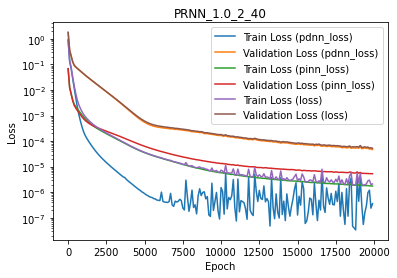

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
reduction_method.initialize_testing_set(50, DEIM=60)
reduction_method.error_analysis(filename="error_analysis")

=                        DEIM error analysis begins for                        =
=               { v_0 * f_12 } * dx(<Mesh #0>[everywhere], {}),                =
=                                    where                                     =
=       f_12 = exp(- 2 * pow(x[0] - mu_0, 2) - 2 * pow(x[1] - mu_1, 2))        =
=               with id 36f87d2cf0b6d3d52f7da4a286d52b5be3491f4c               =

:::::::::::::::::::::::::::::::::::: DEIM 0 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 1 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 2 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 3 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 4 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 5 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 6 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::


###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###################################### 11 ######################################
###########################


=                     GaussianDEIM RB error analysis ends                      =



#### 4.6.2 PINN Error Analysis

In [18]:
test_mu = torch.tensor(reduction_method.testing_set)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.002123971173374619	0.0017889887068360706	1.9373326255269834e-07
mean	0.007890097724856241	0.007484336324449264	0.0012881639865821733
max	0.0476674427450675	0.047667442881904006	0.006569078032147677


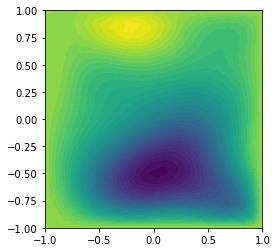

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (0.3, -1.0), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	6.262694005947031e-05	6.262766497891008e-05	1.9373326255269834e-07
mean	0.13245292262851535	0.13244015905011705	0.0012881639865821733
max	0.3166468733165758	0.3165855567176369	0.006569078032147677


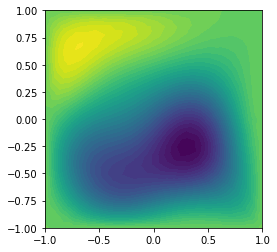

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (0.3, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0003375287433559263	0.00033752854011220504	1.9373326255269834e-07
mean	0.008360335563455872	0.008153328062235976	0.0012881639865821733
max	0.06279532198446197	0.06245212875688345	0.006569078032147677


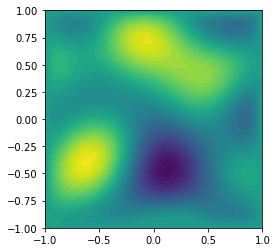

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (0.3, -1.0), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for 20 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.007890097724856241	0.007484336324449264	0.0012881639865821733
pdnn_net	0.13245292262851535	0.13244015905011705	0.0012881639865821733
prnn_net	0.008360335563455872	0.008153328062235976	0.0012881639865821733
#####################################################################################
